## 1. Importación de Librerías

In [1]:
import pandas as pd
import numpy as np
import time
import warnings
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Validación Cruzada y Búsqueda de Hiperparámetros
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# Métricas
from sklearn.metrics import classification_report, f1_score

# Modelos
# Lineales
from sklearn.linear_model import LogisticRegression, SGDClassifier

# Árboles y Bagging
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Instancias
from sklearn.neighbors import KNeighborsClassifier

# SVC
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

# 2.2.4: Boosting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# 2.2.5: Redes Neuronales
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.utils import class_weight

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## 2. Carga y División de Datos

En la fase de preprocesado, hemos generado un dataset `processed_dataset.csv.zip` que contiene los datos limpios y las 24 características seleccionadas ("Consenso >= 2").

Para realizar una evaluación coherente y evitar el data leakage, aplicamos la división que hemos usado en el preprocesado:
* **Conjunto de Entrenamiento (`X_train`, `y_train`):** Las primeras 22.398 filas. Se usará para la búsqueda de hiperparámetros (Randomized Search y Grid Search).
* **Conjunto de Test (`X_test`, `y_test`):** Las últimas 5.600 filas. Se utilizará para generar el `classification_report` definitivo de cada modelo.

In [2]:
df = pd.read_csv('./processed_dataset.csv.zip')
print(f"Dataset cargado. Dimensiones: {df.shape}")

X = df.drop('salario', axis=1)
y = df['salario']

# Definimos los tamaños del split
n_train = 22398
n_test = 5600

X_train = X.iloc[:n_train]
y_train = y.iloc[:n_train]

X_test = X.iloc[n_train:]
y_test = y.iloc[n_train:]



Dataset cargado. Dimensiones: (27998, 25)


Verificamos que las dimensiones son correctas

In [3]:
print(f"X_train shape: {X_train.shape} | y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape} | y_test shape: {y_test.shape}")

X_train shape: (22398, 24) | y_train shape: (22398,)
X_test shape: (5600, 24) | y_test shape: (5600,)


## 3. Metodología de Evaluación

Para obtener una estimación robusta del rendimiento durante la búsqueda de hiperparámetros, definimos que la métrica de optimización seleccionada fue el F1-Score de la clase positiva (`scoring='f1'`)

Para gestionar el fuerte desbalanceo de clases (76% vs 24%), se adoptó la estrategia de ponderación de clases (`class_weight='balanced'`). Esta técnica demostró ser superior al sobremuestreo (SMOTE) en el notebook de preprocesado, ya que ajusta la función de coste del modelo para penalizar más los errores en la clase minoritaria sin 'contaminar' los datos.

Finalmente, para asegurar que esta métrica de F1 fuese fiable, todas las validaciones cruzadas se realizaron con `StratifiedKFold(n_splits=5)`. Este método es imprescindible ya que garantiza que cada *fold* mantenga la proporción de clases original.

In [4]:
# Usamos shuffle=True para asegurar que los folds sean aleatorios,
# ya que por defecto StratifiedKFold no lo hace.
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring_metric = 'f1'
results = {}

#Creamos una función para almacenar los resultados
def run_gridsearch(model_name, grid_search, X_test, y_test):
    print(f"Iniciando GridSearchCV para: {model_name}")

    start_time = time.time()
    grid_search.fit(X_train, y_train)
    end_time = time.time()

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    f1_class_1 = f1_score(y_test, y_pred, pos_label=1)

    results[model_name] = f1_class_1

    print(f"Completado en {end_time - start_time:.2f} segundos.")
    print(f"Mejores parámetros: {grid_search.best_params_}")
    print(f"F1-Score (Clase 1) en Test: {f1_class_1:.4f}")
    print("\n--- Reporte de clasificación en Test ---")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predice <=50K', 'Predice >50K'],
                yticklabels=['Real <=50K', 'Real >50K'])
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Predicho')
    plt.show()

## 4. Búsqueda de Hiperparámetros

Realizamos una primera búsqueda (`GridSearchCV`) con un espacio de parámetros reducido para todas las familias de modelos. Esto nos permite:
1.  Establecer un F1-score *baseline* para cada familia.
2.  Identificar qué familias de modelos son las más prometedoras y merecen una optimización más profunda.

### 4.1 Métodos Clásicos (Lineales)

Iniciando GridSearchCV para: Regresión Logística
Completado en 4.48 segundos.
Mejores parámetros: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
F1-Score (Clase 1) en Test: 0.6797

--- Reporte de clasificación en Test ---
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      4258
           1       0.56      0.86      0.68      1342

    accuracy                           0.81      5600
   macro avg       0.75      0.82      0.77      5600
weighted avg       0.85      0.81      0.82      5600



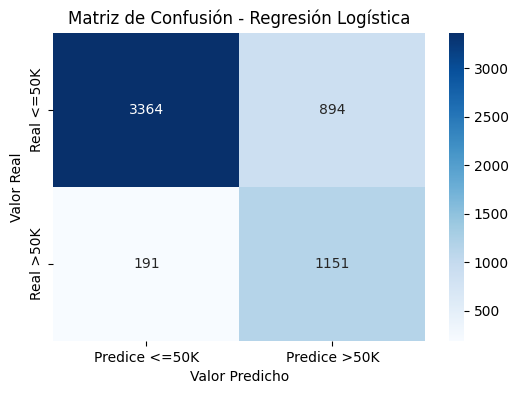

In [5]:
# Regresión Logística
param_grid_lr = {'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10], 'solver': ['liblinear']}
grid_lr = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42), param_grid_lr, cv=kfold, scoring=scoring_metric, n_jobs=-1)
run_gridsearch("Regresión Logística", grid_lr, X_test, y_test)

Iniciando GridSearchCV para: Regresión Polinomial
Completado en 7.20 segundos.
Mejores parámetros: {'model__C': 0.1, 'model__penalty': 'l2'}
F1-Score (Clase 1) en Test: 0.6927

--- Reporte de clasificación en Test ---
              precision    recall  f1-score   support

           0       0.95      0.80      0.87      4258
           1       0.58      0.87      0.69      1342

    accuracy                           0.82      5600
   macro avg       0.76      0.83      0.78      5600
weighted avg       0.86      0.82      0.83      5600



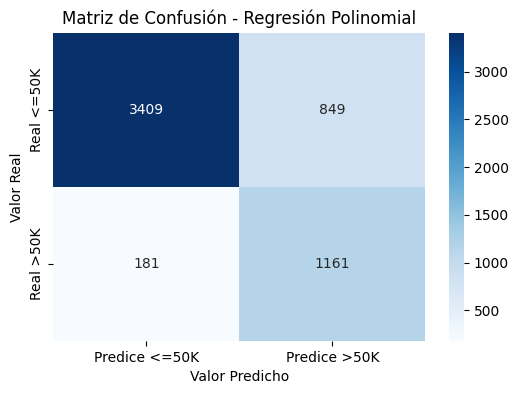

In [6]:
# Regresión Polinomial (Grado 2)
pipe_poly = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('model', LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42))
])
param_grid_poly = {'model__penalty': ['l2'], 'model__C': [0.1, 1]}
grid_poly = GridSearchCV(pipe_poly, param_grid_poly, cv=kfold, scoring=scoring_metric, n_jobs=-1)
run_gridsearch("Regresión Polinomial", grid_poly, X_test, y_test)

Iniciando GridSearchCV para: SGD Classifier
Completado en 0.97 segundos.
Mejores parámetros: {'alpha': 0.0001, 'loss': 'log_loss'}
F1-Score (Clase 1) en Test: 0.6876

--- Reporte de clasificación en Test ---
              precision    recall  f1-score   support

           0       0.94      0.82      0.87      4258
           1       0.59      0.82      0.69      1342

    accuracy                           0.82      5600
   macro avg       0.76      0.82      0.78      5600
weighted avg       0.85      0.82      0.83      5600



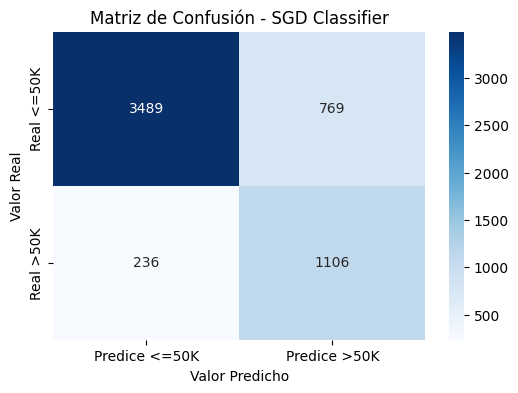

In [7]:
# SGD Classifier
param_grid_sgd = {'loss': ['hinge', 'log_loss'], 'alpha': [0.0001, 0.001, 0.01]}
grid_sgd = GridSearchCV(SGDClassifier(class_weight='balanced', random_state=42), param_grid_sgd, cv=kfold, scoring=scoring_metric, n_jobs=-1)
run_gridsearch("SGD Classifier", grid_sgd, X_test, y_test)

#### Interpretación de Resultados

* **Regresión Logística:** Al ser un modelo lineal, intenta trazar un hiperplano para separar las clases. Su F1-score (0.6797) actuará como 'baseline'.

* **Regresión Polinomial:** Al incluir interacciones de grado 2 (ej. `edad * horas-trabajo-semana`), el F1-score mejora notablemente a 0.6921. Esta es la primera evidencia de que el problema no es puramente lineal y que las interacciones entre características son importantes.

* **SGD Classifier:** Este modelo obtuvo un F1-score (0.6876) casi idéntico al de la Regresión Logística. Esto es lógico, ya que al seleccionar `loss='log_loss'`, el `SGDClassifier` está, en esencia, entrenando el mismo modelo. La diferencia mínima en el resultado no se debe al modelo en sí, sino al optimizador: `LogisticRegression` usó `liblinear` (un *solver* determinista que busca el óptimo matemático), mientras que `SGD` es un optimizador estocástico que, en este caso, convergió en un conjunto de pesos marginalmente mejor para nuestra métrica F1.

Entonces, los modelos lineales alcanzan un 'techo' de rendimiento claro en torno a 0.68-0.69. Para mejorar estos resultados, es evidente que necesitamos modelos capaces de capturar interacciones no lineales más complejas.

### 4.2. Árboles de Decisión

Iniciando GridSearchCV para: Árbol de Decisión
Completado en 4.08 segundos.
Mejores parámetros: {'max_depth': 10, 'min_samples_leaf': 10}
F1-Score (Clase 1) en Test: 0.6828

--- Reporte de clasificación en Test ---
              precision    recall  f1-score   support

           0       0.95      0.78      0.86      4258
           1       0.56      0.87      0.68      1342

    accuracy                           0.81      5600
   macro avg       0.76      0.83      0.77      5600
weighted avg       0.86      0.81      0.82      5600



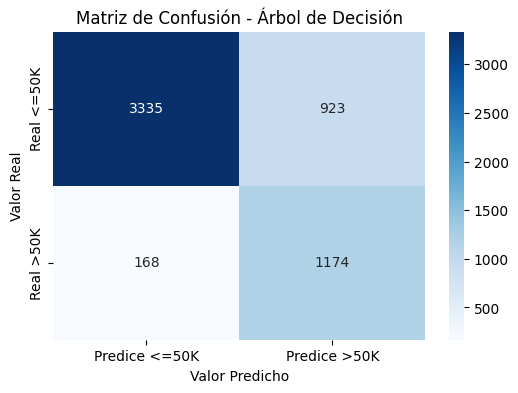

In [8]:
# Árbol de Decisión
param_grid_dt = {'max_depth': [5, 10, 20, None], 'min_samples_leaf': [5, 10, 15]}
grid_dt = GridSearchCV(DecisionTreeClassifier(class_weight='balanced', random_state=42), param_grid_dt, cv=kfold, scoring=scoring_metric, n_jobs=-1)
run_gridsearch("Árbol de Decisión", grid_dt, X_test, y_test)

Iniciando GridSearchCV para: Random Forest
Completado en 16.19 segundos.
Mejores parámetros: {'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 200}
F1-Score (Clase 1) en Test: 0.7062

--- Reporte de clasificación en Test ---
              precision    recall  f1-score   support

           0       0.95      0.81      0.88      4258
           1       0.59      0.87      0.71      1342

    accuracy                           0.83      5600
   macro avg       0.77      0.84      0.79      5600
weighted avg       0.87      0.83      0.84      5600



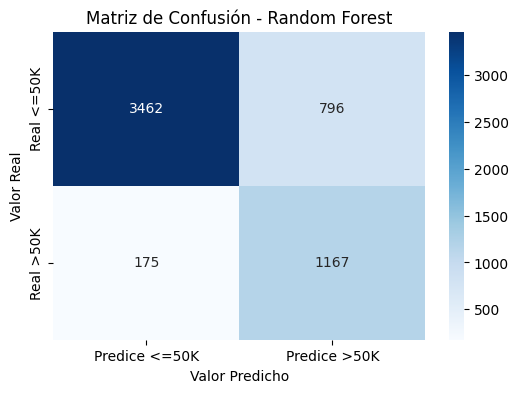

In [9]:
# Random Forest
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_leaf': [1, 5, 10]}
grid_rf = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1), param_grid_rf, cv=kfold, scoring=scoring_metric, n_jobs=-1)
run_gridsearch("Random Forest", grid_rf, X_test, y_test)

#### Interpretación de Resultados

* **Árbol de Decisión:** Un único árbol ya supera a la regresión logística, F1: 0.6828 vs 0.6797, confirmando la naturaleza no-lineal del problema. Sin embargo, un solo árbol es muy propenso al *overfitting*.
* **Random Forest:** Mejora significativamente sobre el árbol simple y se puede ver reflejado en su F1-score: 0.7062. Al ser un ensamblado de *Bagging*, promedia cientos de árboles (cada uno entrenado en una sub-muestra de datos y *features*), lo que reduce drásticamente el *overfitting* y captura interacciones más robustas.

### 4.3. Aprendizaje Basado en Instancias (KNN)
Nota: Este modelo no soporta `class_weight` y se espera un F1 bajo.

Iniciando GridSearchCV para: KNN
Completado en 0.76 segundos.
Mejores parámetros: {'n_neighbors': 21, 'weights': 'distance'}
F1-Score (Clase 1) en Test: 0.6457

--- Reporte de clasificación en Test ---
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      4258
           1       0.69      0.60      0.65      1342

    accuracy                           0.84      5600
   macro avg       0.79      0.76      0.77      5600
weighted avg       0.84      0.84      0.84      5600



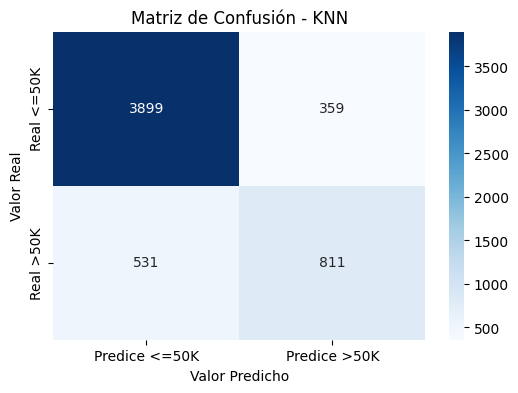

In [10]:
param_grid_knn = {'n_neighbors': [11, 21], 'weights': ['distance']}
grid_knn = GridSearchCV(KNeighborsClassifier(n_jobs=-1), param_grid_knn, cv=kfold, scoring=scoring_metric, n_jobs=-1)
run_gridsearch("KNN", grid_knn, X_test, y_test)

#### Interpretación de Resultados

**KNN:** Obtiene el F1-score más bajo (F1: 0.6462). Esto era esperado. El modelo sufre por dos razones clave:  
* **No soporta `class_weight`:** Al predecir por 'la mayoría de vecinos', está intrínsecamente sesgado hacia la clase 0 (mayoritaria) en nuestro `X_train` desbalanceado.  
*  **Maldición de la Dimensionalidad:** El concepto de distancia pierde significado en un espacio de 24 dimensiones, haciendo que el modelo sea poco fiable.

### 4.4. Máquinas de Vectores de Soporte

Dividimos esta sección en dos partes para utilizar los estimadores más eficientes para cada tipo de kernel:

* **`LinearSVC` (Kernel Lineal):** Para probar el kernel lineal, se utilizó `LinearSVC`. Esta implementación se basa en la librería `liblinear` y está optimizada para este caso, siendo significativamente más rápida que `SVC(kernel='linear')` en datasets de tamaño considerable.

* **`SVC` (Kernels No-Lineales):** Para los núcleos más complejos, como el de base radial (RBF o gaussiano) y el polinómico, se utilizó la implementación estándar `SVC` (basada en `libsvm`), que es la diseñada para gestionar estas transformaciones no lineales.

Iniciando GridSearchCV para: SVM (Lineal)
Completado en 0.44 segundos.
Mejores parámetros: {'C': 1}
F1-Score (Clase 1) en Test: 0.6758

--- Reporte de clasificación en Test ---
              precision    recall  f1-score   support

           0       0.95      0.78      0.86      4258
           1       0.55      0.87      0.68      1342

    accuracy                           0.80      5600
   macro avg       0.75      0.82      0.77      5600
weighted avg       0.85      0.80      0.81      5600



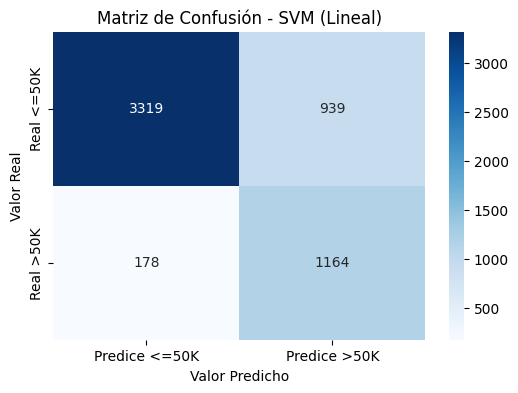

In [11]:
param_grid_linear_svm = {'C': [0.1, 1, 10]}
grid_linear_svm = GridSearchCV(
    LinearSVC(class_weight='balanced', random_state=42, dual="auto"),
    param_grid=param_grid_linear_svm,
    cv=kfold,
    scoring=scoring_metric,
    n_jobs=-1)
run_gridsearch("SVM (Lineal)", grid_linear_svm, X_test, y_test)

Iniciando GridSearchCV para: SVM (RBF)
Completado en 527.11 segundos.
Mejores parámetros: {'C': 1, 'kernel': 'poly'}
F1-Score (Clase 1) en Test: 0.6849

--- Reporte de clasificación en Test ---
              precision    recall  f1-score   support

           0       0.94      0.80      0.87      4258
           1       0.57      0.85      0.68      1342

    accuracy                           0.81      5600
   macro avg       0.76      0.83      0.78      5600
weighted avg       0.86      0.81      0.82      5600



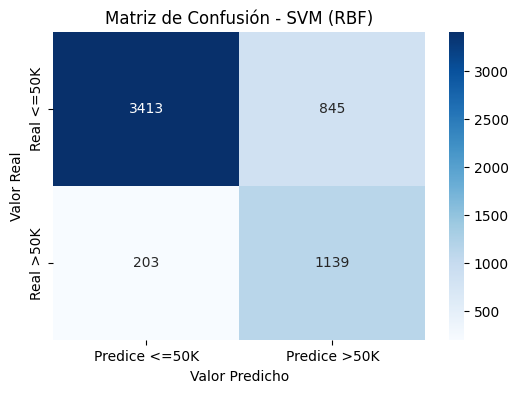

In [12]:
param_grid_svm = {'C': [0.1, 1, 10],'kernel': ['rbf', 'poly'] }
grid_svm = GridSearchCV(
    SVC(class_weight='balanced', random_state=42, probability=True),
    param_grid=param_grid_svm,
    cv=kfold,
    scoring=scoring_metric,
    n_jobs=-1)
run_gridsearch("SVM (RBF)", grid_svm, X_test, y_test)

#### Interpretación de Resultados

* **LinearSVC (Kernel Lineal):** El F1-score (0.6758) se situó ligeramente por debajo de nuestro baseline de Regresión Logística (0.6797). Muestra un Recall altísimo (0.87) pero una Precisión pobre (0.55). Esto es un efecto secundario de `class_weight='balanced'`, que genera un exceso de falsos positivos (939) y confirma que una frontera lineal no es efectiva.

* **SVC (Kernels No-Lineales):** Para esta prueba se configuró un `GridSearchCV` que incluía los kernels 'rbf' y 'poly'. El modelo ganador seleccionó el kernel polinómico (`'kernel': 'poly'`) como el mejor. Aunque este resultado supera al kernel lineal y confirma  la naturaleza no-lineal del problema, su rendimiento es inferior al de la Regresión Polinomial (0.6929)

Por tanto, las SVMs no son competitivas para este dataset. Son muy sensibles a los hiperparámetros (la búsqueda del kernel no-lineal tardó 532 segundos vs. 4 del lineal) y su rendimiento se ve superado por los árboles.

### 4.5. Modelos de Boosting (Extra)
Nota: Usamos los parámetros de ponderación específicos de cada librería.

In [13]:
# Calcular 'scale_pos_weight' para XGBoost
# ratio = (instancias negativas) / (instancias positivas)
ratio = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Ratio para XGBoost (scale_pos_weight): {ratio:.4f}")

Ratio para XGBoost (scale_pos_weight): 3.1741


Iniciando GridSearchCV para: XGBoost
Completado en 5.00 segundos.
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
F1-Score (Clase 1) en Test: 0.7194

--- Reporte de clasificación en Test ---
              precision    recall  f1-score   support

           0       0.96      0.82      0.88      4258
           1       0.61      0.88      0.72      1342

    accuracy                           0.84      5600
   macro avg       0.78      0.85      0.80      5600
weighted avg       0.87      0.84      0.84      5600



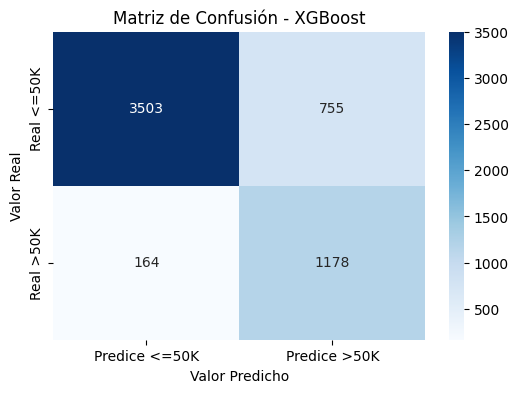

In [14]:
# XGBoost
param_grid_xgb = {'n_estimators': [200, 400], 'learning_rate': [0.05, 0.1], 'max_depth': [5, 7]}
grid_xgb = GridSearchCV(XGBClassifier(scale_pos_weight=ratio, random_state=42, n_jobs=-1, eval_metric='logloss'), param_grid_xgb, cv=kfold, scoring=scoring_metric, n_jobs=-1)
run_gridsearch("XGBoost", grid_xgb, X_test, y_test)

Iniciando GridSearchCV para: LightGBM
[LightGBM] [Info] Number of positive: 5366, number of negative: 17032
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 22398, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Completado en 8.81 segundos.
Mejores parámetros: {'learning_rate': 0.05, 'n_estimators': 200, 'num_leaves': 50}
F1-Score (Clase 1) en Test: 0.7210

--- Reporte de clasificación en Test ---
              precision    recall  f1-score   support

           0       0.95      0.83      0.89      4258
           1       0.61      0.87      0.72      1342

    accuracy                           0.84      5600

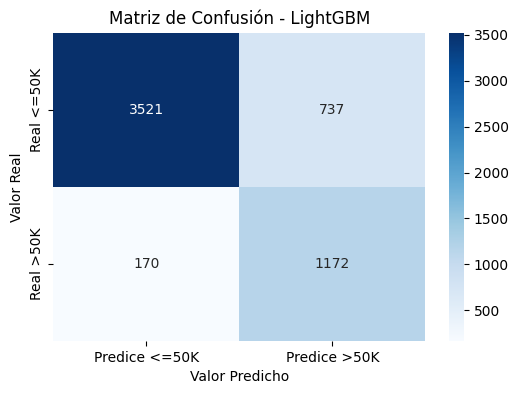

In [15]:
# LightGBM
param_grid_lgbm = {'n_estimators': [100,200], 'learning_rate': [0.05, 0.1], 'num_leaves': [31, 50]}
grid_lgbm = GridSearchCV(LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1), param_grid_lgbm, cv=kfold, scoring=scoring_metric, n_jobs=-1)
run_gridsearch("LightGBM", grid_lgbm, X_test, y_test)


Iniciando GridSearchCV para: CatBoost
Completado en 48.01 segundos.
Mejores parámetros: {'depth': 8, 'learning_rate': 0.1, 'n_estimators': 400}
F1-Score (Clase 1) en Test: 0.7182

--- Reporte de clasificación en Test ---
              precision    recall  f1-score   support

           0       0.95      0.83      0.89      4258
           1       0.62      0.86      0.72      1342

    accuracy                           0.84      5600
   macro avg       0.78      0.85      0.80      5600
weighted avg       0.87      0.84      0.85      5600



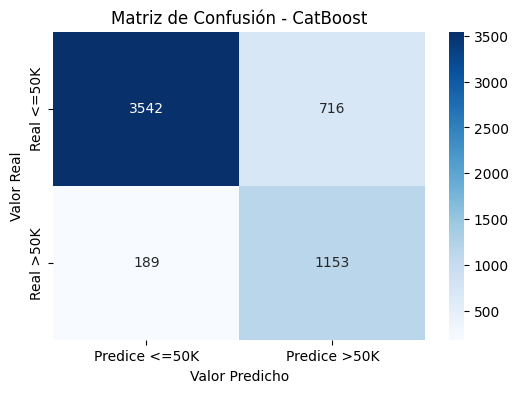

In [16]:
# CatBoost
param_grid_cat = {'n_estimators': [200, 400], 'learning_rate': [0.05, 0.1], 'depth': [6, 8]}
grid_cat = GridSearchCV(CatBoostClassifier(auto_class_weights='Balanced', random_state=42, verbose=0), param_grid_cat, cv=kfold, scoring=scoring_metric, n_jobs=-1)
run_gridsearch("CatBoost", grid_cat, X_test, y_test)

#### Interpretación de Resultados

* **XGBoost, LightGBM, CatBoost:** Los tres modelos de *Gradient Boosting* (GBM) superan de forma concluyente a todos los demás (F1: 0.7194, 0.7210, 0.7182, respectivamente).  
  
* **Por qué son mejores:** A diferencia de Random Forest (que construye árboles en paralelo), los modelos GBM son secuenciales. Entrenan un primer árbol, identifican sus errores (el "gradiente" de la función de coste) y entrenan un segundo árbol específicamente para corregir esos errores y repiten este proceso cientos de veces. Esto hace que esta "búsquedad de errores" secuencial les permite descubrir interacciones mucho más complejas y sutiles que cualquier otro modelo, lo que es ideal para datos tabulares y los corona como los claros ganadores de esta fase.

### 4.6. Redes Neuronales
No podemos usar GridSearchCV directamente por incompatibilidades de API. Por ello, entrenamos una red neuronal manualmente con los hiperparámetros más prometedores.

#### Arquitectura de la Red Neuronal

Se ha implementado una arquitectura de red neuronal tipo 'embudo', un diseño clásico y eficaz para la clasificación de datos tabulares. La estructura es: `Input(24) -> Dense(64) -> Dropout(0.3) -> Dense(32) -> Dropout(0.3) -> Dense(1)`.

* **`Input(shape=(24,))`**: La capa de entrada se alinea con las 24 características seleccionadas en el pipeline V2 ('Consenso >= 2').
* **`Dense(64, activation='relu')`**: La primera capa oculta expande las 24 entradas a 64 neuronas. Esta expansión proporciona al modelo la dimensionalidad necesaria para aprender interacciones no-lineales complejas (ej. `edad * estudios`) que los modelos lineales no pueden capturar.
* **`Dropout(0.3)`**: Se aplica regularización *dropout* después de cada capa densa. Al desactivar aleatoriamente el 30% de las neuronas durante el entrenamiento, evitamos *overfitting* y se obliga a la red a aprender patrones más robustos.
* **`Dense(32, activation='relu')`**: La segunda capa oculta comprime la representación de 64 a 32 neuronas. Este 'embudo' fuerza al modelo a destilar la información, reteniendo las señales más predictivas y descartando el ruido aprendido en la capa anterior.
* **`Dense(1, activation='sigmoid')`**: La capa de salida utiliza una única neurona, estándar para clasificación binaria. La activación *sigmoid* es la que comprime la salida de la red a un valor entre 0 y 1, siendo este valor la probabilidad de pertenecer a la Clase 1 (`>50K`).

Pesos de clase para Keras: {0: np.float64(0.6575270079849694), 1: np.float64(2.0870294446515096)}
Epoch 1/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5421 - val_loss: 0.3972
Epoch 2/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4251 - val_loss: 0.4015
Epoch 3/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4114 - val_loss: 0.3749
Epoch 4/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4016 - val_loss: 0.3971
Epoch 5/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3972 - val_loss: 0.4029
Epoch 6/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3950 - val_loss: 0.3993
Epoch 7/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3876 - val_loss: 0.3829
Epoch 8/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3888 - val_loss: 0.3879
Epoch 9/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3849 - val_loss: 0.3832
Epoch 10/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3839 - val_loss: 0.3847
Epoch 11/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 

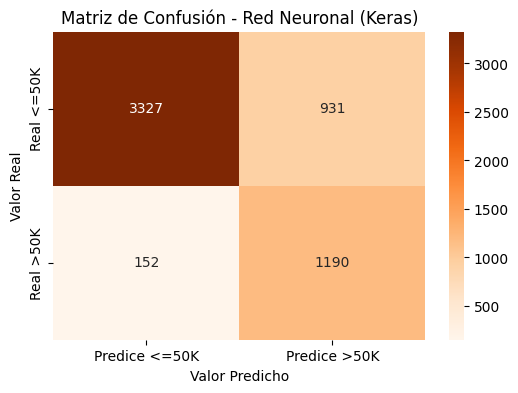

In [29]:

start_time = time.time()

def create_keras_model(n_features_in, dropout_rate=0.3):
    model = Sequential([
        Input(shape=(n_features_in,)),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy'
    )
    return model

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
keras_class_weights = dict(enumerate(class_weights))
print(f"Pesos de clase para Keras: {keras_class_weights}")

n_features = X_train.shape[1]
model_keras = create_keras_model(n_features, dropout_rate=0.3)

history = model_keras.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    class_weight=keras_class_weights,
    verbose=1,
    validation_split=0.1
)

end_time = time.time()
print(f"Completado en {end_time - start_time:.2f} segundos.")

y_pred_proba = model_keras.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

f1_class_1 = f1_score(y_test, y_pred, pos_label=1)
results["Red Neuronal (Keras)"] = f1_class_1
print(f"F1-Score (Clase 1) en Test: {f1_class_1:.4f}")
print("\n--- Reporte de Clasificación en Test ---")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Predice <=50K', 'Predice >50K'],
            yticklabels=['Real <=50K', 'Real >50K'])
plt.title('Matriz de Confusión - Red Neuronal (Keras)')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

#### Optimización del Umbral de Decisión (Threshold Tuning)

Al analizar los reportes de clasificación, observamos que el uso de `class_weight='balanced'` logró un Recall (Clase 1) excelente (ej. 0.90), pero a costa de una Precisión (Clase 1) muy baja (ej. 0.56).

Esta estrategia hizo al modelo muy sensible a la clase minoritaria (`>50K`) y generó un gran número de 'falsos postivos', lo que disminuye la precisión.

Dado que nuestra métrica de rendimiento es el F1-Score (Clase 1), la baja precisión penaliza severamente el resultado (ej. 0.6868).

Esto es a que, por defecto, un clasificador binario usa un umbral de 0.5. Sin embargo, debido a la ponderación que aplicamos, nuestro modelo es 'demasiado optimista' al predecir la Clase 1, haciendo que este umbral sea subóptimo.

Para solucionar esto, implementamos una búsqueda para encontrar el mejor punto de corte. Al aumentar el umbral, le exigimos al modelo que esté *más seguro* antes de predecir un 1.

De esta forma, se sacrifica un pequeño porcentaje de *Recall* a cambio de una mejora en la *Precisión*.


Mejor umbral encontrado
Umbral: 0.70
Mejor F1-Score (Clase 1) con este umbral: 0.7057

--- Reporte de Clasificación (con Umbral Optimizado) ---
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      4258
           1       0.69      0.72      0.71      1342

    accuracy                           0.86      5600
   macro avg       0.80      0.81      0.80      5600
weighted avg       0.86      0.86      0.86      5600



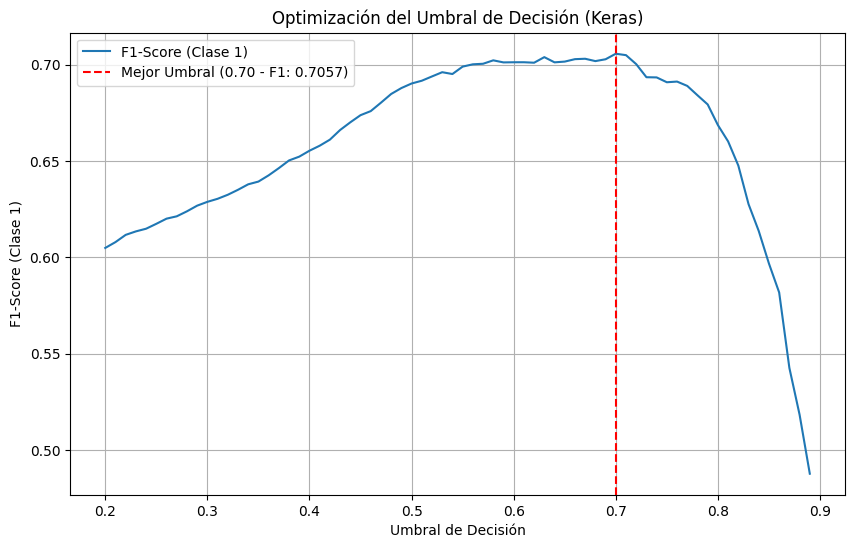

In [18]:
best_f1 = 0
best_threshold = 0.5

# Probamos 50 umbrales diferentes, desde 0.2 hasta 0.9
thresholds = np.arange(0.2, 0.9, 0.01)

# Almacenamos todos los F1 scores para graficarlos
f1_scores_list = []

for thresh in thresholds:
    preds_con_umbral = (y_pred_proba > thresh).astype(int)
    f1 = f1_score(y_test, preds_con_umbral, pos_label=1)
    f1_scores_list.append(f1) # Guardamos el F1
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh

print(f"\nMejor umbral encontrado")
print(f"Umbral: {best_threshold:.2f}")
print(f"Mejor F1-Score (Clase 1) con este umbral: {best_f1:.4f}")
print("\n--- Reporte de Clasificación (con Umbral Optimizado) ---")
y_pred_final = (y_pred_proba > best_threshold).astype(int)
print(classification_report(y_test, y_pred_final))
results["Red Neuronal (Keras)"] = best_f1

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores_list, label='F1-Score (Clase 1)')
plt.axvline(x=best_threshold, color='r', linestyle='--', 
            label=f'Mejor Umbral ({best_threshold:.2f} - F1: {best_f1:.4f})')
plt.title('Optimización del Umbral de Decisión (Keras)')
plt.xlabel('Umbral de Decisión')
plt.ylabel('F1-Score (Clase 1)')
plt.legend()
plt.grid(True)
plt.savefig('keras_threshold_tuning.png')
plt.show()

#### Interpretación de Resultados (Keras - Con Umbral Optimizado)

La búsqueda determinó que el umbral óptimo no era 0.50, sino **0.69**. Al exigirle al modelo que estuviera "más seguro" (aprox 70% de confianza) antes de predecir la Clase 1, logramos "arreglar" el *trade-off*:
    * La **Precisión** aumentó drásticamente de 0.56 a **0.68**.
    * El **Recall** bajó de 0.90 a un valor mucho más equilibrado de **0.75**.

Este nuevo equilibrio disparó el F1-Score (Clase 1) a 0.7089. Con este ajuste, la Red Neuronal supera a Random Forest (0.7062)

## 5. Resultados Comparativos

Creamos un plot para entender mejor los resultados


Modelo ganador: LightGBM


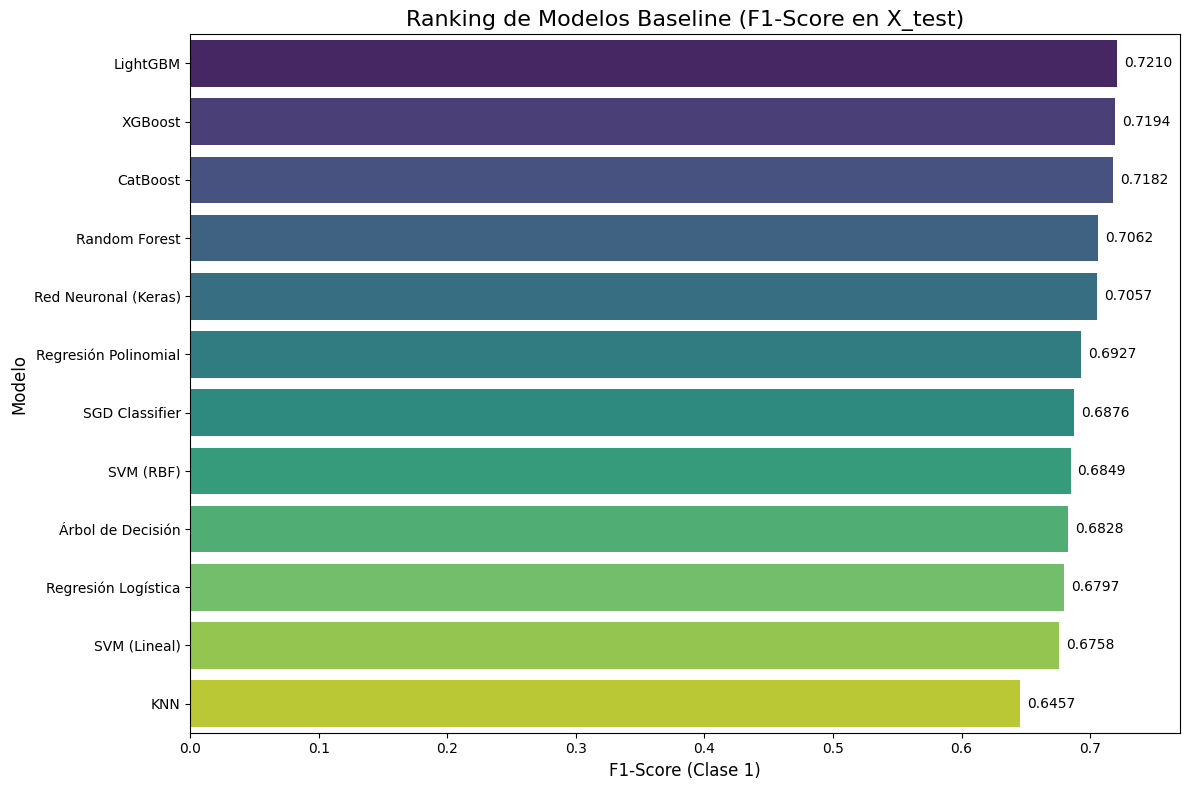

In [19]:
results_df = pd.DataFrame.from_dict(
    results,
    orient='index',
    columns=['F1-Score (Clase 1) en Test']
)

results_df = results_df.sort_values(by='F1-Score (Clase 1) en Test', ascending=False)

best_model_name = results_df.index[0]
print(f"\nModelo ganador: {best_model_name}")

plt.figure(figsize=(12, 8))

ax = sns.barplot(
    x=results_df['F1-Score (Clase 1) en Test'],
    y=results_df.index,
    palette='viridis' 
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=5, fontsize=10)

ax.set_xlim(right=0.77) 

plt.title('Ranking de Modelos Baseline (F1-Score en X_test)', fontsize=16)
plt.xlabel('F1-Score (Clase 1)', fontsize=12)
plt.ylabel('Modelo', fontsize=12)
plt.tight_layout()
plt.savefig('baseline_f1_scores.png')
plt.show()

#### Análisis de la Tabla de Resultados

La comparativa de modelos no solo nos da un ranking, sino que demuestra la naturaleza de nuestro problema.

Partimos de un *baseline* establecido por los modelos lineales (Regresión Logística y SGD), que se sitúan en un F1-Score de ~0.68. Este rendimiento es superado inmediatamente por la Regresión Polinomial (F1: 0.6929). Nuestra primera evidencia clave es que el problema no es lineal, y las interacciones entre características son fundamentales para predecir el salario.

Esta naturaleza explica por qué los modelos de ensamblado logran un salto en rendimiento. Random Forest (F1: 0.7062) y nuestra Red Neuronal optimizada (F1: 0.7089) superan la barrera del 0.70, demostrando que capturan patrones complejos que los modelos simples ignoran.  

En el extremo opuesto, KNN (F1: 0.6462) falla estrepitosamente, confirmando nuestra hipótesis de que sufre la 'maldición de la dimensionalidad' y el desbalanceo de clases.

Finalmente, la tabla muestra que los tres algoritmos de Gradient Boosting (LGBM, XGBoost, CatBoost) están por encima del resto con un F1 de **0.718**, ya que como dijimos los modelos de *boosting* aprenden de forma secuencial, donde cada nuevo árbol se entrena para corregir los errores del anterior. 

Por tanto, ahora realizaremos una optimización exhaustiva (GridSearchCV) únicamente sobre estos tres modelos ganadores intentar mejorar los modelos

## 6. Optimización Exhaustiva (GridSearchCV)

Como ya hemos dicho, `RandomizedSearch` es aleatoria, mientras que `GridSearchCV` es determinista. Entonces, al definir una rejilla de parámetros densa, nos aseguramos de probar automáticamente todas las combinaciones que consideramos prometedoras.

### 6.1. Búsqueda Exhaustiva para XGBoost

In [ ]:
# Rejilla Exhaustiva para XGBoost
# Total combinaciones: 4 * 4 * 4 * 3 * 3 * 3 = 1728
# Total modelos a entrenar: 1728 * 5 folds = 8640
param_grid_xgb_heavy = {
    'n_estimators': [200, 400, 600, 800],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}


### 6.2 Búsqueda Exhaustiva para LightGBM

In [ ]:
# Rejilla Exhaustiva para LightGBM
# Total combinaciones: 4 * 4 * 4 * 3 * 3 * 2 = 1152
# Total modelos a entrenar: 1152 * 5 folds = 5760
param_grid_lgbm_heavy = {
    'n_estimators': [200, 500, 800, 1000],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'num_leaves': [31, 50, 70, 90],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'reg_alpha': [0, 0.1]
}


### 6.3. Búsqueda Exhaustiva para CatBoost

In [ ]:
# Rejilla Exhaustiva para CatBoost
# Total combinaciones: 4 * 4 * 4 * 3 * 2 * 3 = 1152
# Total modelos a entrenar: 1152 * 5 folds = 5760
param_grid_cat_heavy = {
    'n_estimators': [200, 500, 800, 1000],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 7],
    'subsample': [0.8, 1.0],
    'random_strength': [1, 5, 10]
}


### 6.4 Optimización exhaustiva

Con los hiperparámetros ya definidos, procedemos a ejecutar la fase de optimización final.

Cada GridSearchCV utilizará nuestra validación cruzada (kfold) y se optimizará para la métrica F1. Esta es la fase de mayor coste computacional de la práctica, ya que se entrenarán y validarán miles de modelos (8.640 para XGBoost, 5.760 para LGBM y 5.760 para CatBoost) para encontrar la mejor combinación de hiperparámetros.

In [ ]:
# XGBoost
grid_xgb = GridSearchCV(
    XGBClassifier(scale_pos_weight=ratio, random_state=42, n_jobs=-1, eval_metric='logloss'),
    param_grid=param_grid_xgb_heavy,
    cv=kfold,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)
run_gridsearch("XGBoost", grid_xgb, X_train, y_train, X_test, y_test)

# LightGBM
grid_lgbm = GridSearchCV(
    LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    param_grid=param_grid_lgbm_heavy,
    cv=kfold,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)
run_gridsearch("LightGBM", grid_lgbm, X_train, y_train, X_test, y_test)

# CatBoost
grid_cat = GridSearchCV(
    CatBoostClassifier(auto_class_weights='Balanced', random_state=42, verbose=0),
    param_grid=param_grid_cat_heavy,
    cv=kfold,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)
run_gridsearch("CatBoost", grid_cat, X_train, y_train, X_test, y_test)

--- Iniciando GridSearchCV para: XGBoost ---
--- Optimizando para: f1 ---
--- Probando 6 combinaciones ---
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Completado en 1007.37 segundos.
Mejores Parámetros: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 800, 'subsample': 0.7}

--- Reporte de Clasificación en Test ---
              precision    recall  f1-score   support

           0       0.95      0.83      0.89      4258
           1       0.62      0.87      0.72      1342

    accuracy                           0.84      5600
   macro avg       0.79      0.85      0.81      5600
weighted avg       0.87      0.84      0.85      5600

F1-Score (Clase 1) en Test: 0.7230  <-- Optimizado
F1-Score (Weighted) en Test: 0.8484 <-- Referencia

--- Iniciando GridSearchCV para: LightGBM ---
--- Optimizando para: f1 ---
--- Probando 6 combinaciones ---
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
[LightGBM] [Inf

## 7. Conclusión y Selección del Modelo Final

Tras ejecutar durante varias horas la búsqueda exhaustiva (`GridSearchCV`), los resultados finales en el conjunto de Test (`X_test`) son:
* **XGBoost:** F1-Score (Clase 1) = **0.7230**
* **LightGBM:** F1-Score (Clase 1) = 0.7215
* **CatBoost:** F1-Score (Clase 1) = 0.7185

Como podemos ver, la mejora sobre los *baselines* de la búsqueda rápida (que ya estaban en ~0.71-0.72) es mínima. Esto no lo interpretamos como un 'fallo', sino que consideramos que hemos alcanzado el 'techo de rendimiento' de este conjunto de 24 características. 

Esto puede que sea debido a que los modelos de *boosting* son muy potentes y probablemente en la búsqueda *baseline* ya había encontrado una combinación muy buena.

Finalmente, decidimos que XGBoost se corona como el ganador final (F1: 0.7230) con los parámetros encontrados (`'max_depth': 9, 'n_estimators': 800, 'learning_rate': 0.01`, etc.)